In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import make_interp_spline, BSpline
import matplotlib.pyplot as plt
import time
import scipy.stats as stats
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
dengue_data = data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Thesis/dengue.csv.gz')


In [ ]:
data['date'] = data['epiweek'].astype(str)
# Set 'date' as the index
data.set_index('date', inplace=True)

In [ ]:
fortaleza = data[data['geocode']==2304400]



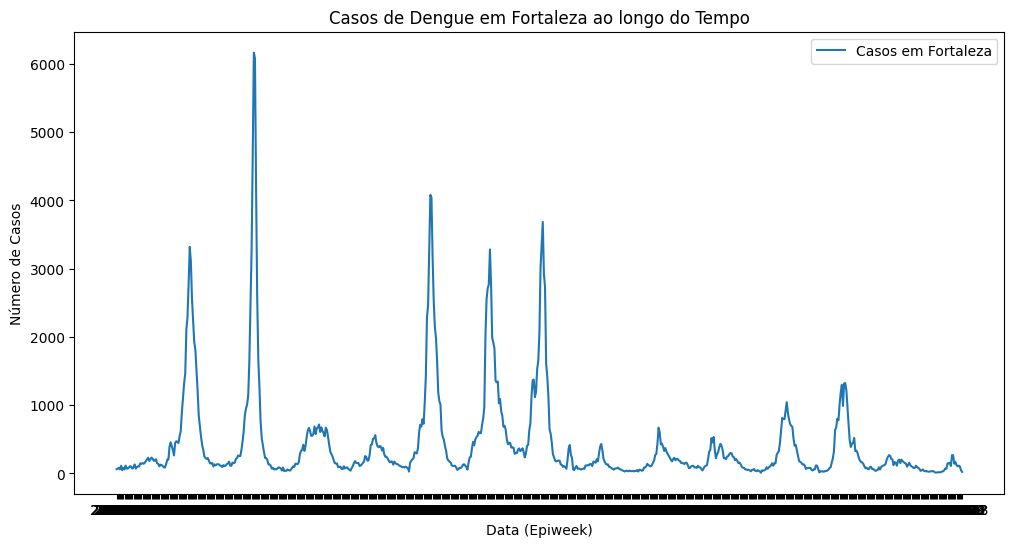

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(fortaleza.index, fortaleza['casos'], label='Casos em Fortaleza')

plt.xlabel('Data (Epiweek)')
plt.ylabel('Número de Casos')
plt.title('Casos de Dengue em Fortaleza ao longo do Tempo')
plt.legend()
plt.grid(False)

plt.show()

In [ ]:
from scipy.ndimage import gaussian_filter1d
sigma = 1.0
epiweek_list = fortaleza['epiweek'].tolist()
cases_list = fortaleza['casos'].tolist()
t_data = fortaleza.index.tolist()
cases_smoothed_gaussian = gaussian_filter1d(cases_list, sigma)

In [ ]:

ini = 40
fin = 200


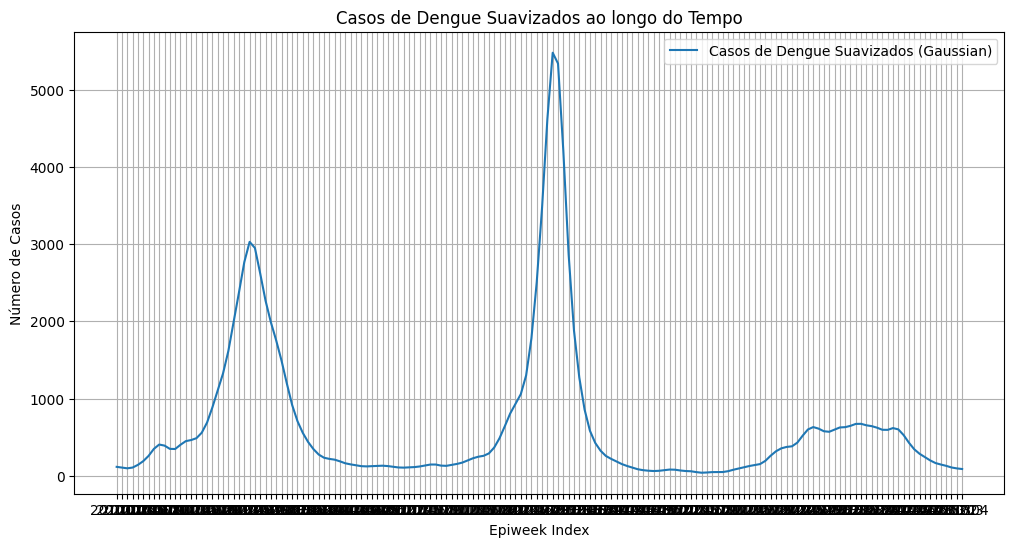

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(t_data[0:160], cases_smoothed_gaussian[ini:fin], label='Casos de Dengue Suavizados (Gaussian)')
plt.xlabel('Epiweek Index')
plt.ylabel('Número de Casos')
plt.title('Casos de Dengue Suavizados ao longo do Tempo')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
cases_normalized = cases_smoothed_gaussian / np.max(cases_smoothed_gaussian)

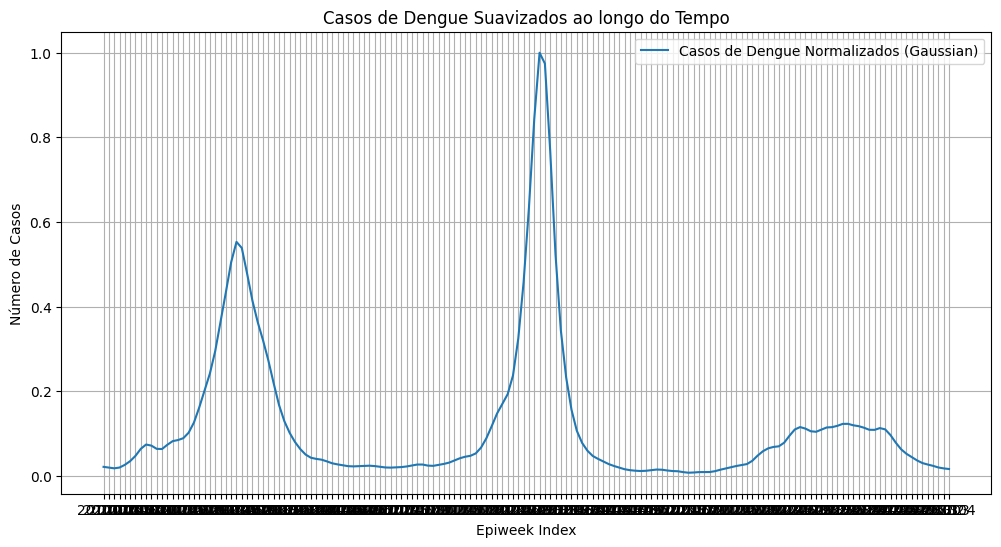

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(t_data[0:160], cases_normalized[ini:fin], label='Casos de Dengue Normalizados (Gaussian)')
plt.xlabel('Epiweek Index')
plt.ylabel('Número de Casos')
plt.title('Casos de Dengue Suavizados ao longo do Tempo')
plt.legend()
plt.grid(True)
plt.show()

Optimization success: True
Optimal parameters: [ 2.49939730e-01  7.49871267e-01  2.58493187e+01  3.80378347e+00
 -1.72501924e-01  7.49967831e-01  8.12913236e+01  3.55432862e+00
  4.99805726e-01  7.49690877e-01  1.06000418e+02  1.33578696e+01
 -3.41525878e-01 -1.59318525e-89  9.99944908e-01  6.90954080e+01
  2.38371448e+01  1.00920074e-01  1.15525770e+02  1.33015303e+01
  1.65688931e-01  9.99441642e-01  4.11589995e-03  1.00558452e-03]


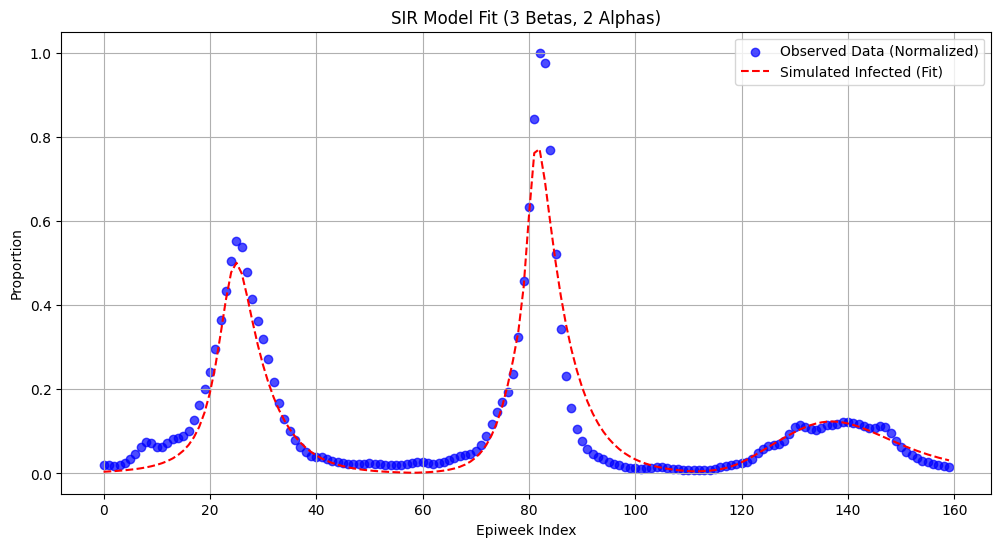

In [ ]:
import numpy as np
from scipy.optimize import minimize, BFGS
import matplotlib.pyplot as plt

# Redefine helper functions locally to ensure they are correct
def gaussian_beta(t, A, t0, sigma, sk):
    denominator = sigma + sk * (t - t0)
    denominator = np.clip(denominator, 1e-6, None) # Avoid division by zero
    return A * np.exp(-0.5 * ((t - t0) / denominator)**2)

def alpha(t, rho, T_c, l):
    return rho * ((1 + np.tanh(t - (T_c - l / 2))) / 2) * ((1 - np.tanh(t - (T_c + l / 2))) / 2)

# Redefine SIR simulator to strictly use floats
def sir_model_simulator(t, beta_values, alpha_values, gamma, S0, I0, R0):
    # Initialize arrays as floats to avoid integer truncation
    S = np.zeros(len(t), dtype=float)
    I = np.zeros(len(t), dtype=float)
    R = np.zeros(len(t), dtype=float)

    S[0] = S0
    I[0] = I0
    R[0] = R0

    for i in range(1, len(t)):
        dt = t[i] - t[i - 1]

        # Current population sum
        N = S[i - 1] + I[i - 1] + R[i - 1]
        if N < 1e-9: N = 1e-9 # Prevent division by zero

        # Derivatives
        dS = -beta_values[i - 1] * S[i - 1] * I[i - 1] / N * dt + alpha_values[i - 1] * R[i - 1] * dt
        dI = (beta_values[i - 1] * S[i - 1] * I[i - 1] / N - gamma * I[i - 1]) * dt
        dR = gamma * I[i - 1] * dt - alpha_values[i - 1] * R[i - 1] * dt

        S[i] = S[i - 1] + dS
        I[i] = I[i - 1] + dI
        R[i] = R[i - 1] + dR

    return S, I, R

# Define data_obs
data_obs = cases_normalized[ini:fin]

def objective_function(params):
    (beta_0, A1, t01, sigma1, sk1,
     A2, t02, sigma2, sk2,
     A3, t03, sigma3, sk3,
     rho_0, rho1, T_c1, l1,
     rho2, T_c2, l2,
     gamma, S0, I0, R0) = params

    t_sim = np.arange(len(data_obs))

    # Calculate beta and alpha
    beta_values = (beta_0 + gaussian_beta(t_sim, A1, t01, sigma1, sk1) +
                   gaussian_beta(t_sim, A2, t02, sigma2, sk2) +
                   gaussian_beta(t_sim, A3, t03, sigma3, sk3))

    alpha_values = rho_0 + alpha(t_sim, rho1, T_c1, l1) + alpha(t_sim, rho2, T_c2, l2)

    # Sanity checks for parameters
    if np.any(np.isnan(beta_values)) or np.any(np.isinf(beta_values)) or \
       np.any(np.isnan(alpha_values)) or np.any(np.isinf(alpha_values)):
        return 1e12

    # Normalize initial conditions
    total_initial = S0 + I0 + R0
    if total_initial <= 0: total_initial = 1e-9
    S0 /= total_initial
    I0 /= total_initial
    R0 /= total_initial

    # Run simulation
    S_sim, I_sim, R_sim = sir_model_simulator(t_sim, beta_values, alpha_values, gamma, S0, I0, R0)

    if np.any(np.isnan(I_sim)) or np.any(np.isinf(I_sim)):
        return 1e12

    sse = (np.sum((I_sim - data_obs)**2)/len(data_obs)) #np.sum((I_sim - data_obs)**2)
    return sse

# Initial parameters and bounds
initial_params = [0.01,    #beta_0
    0.5, 10.0, 10.0, 0.01,  # A1, t01, sigma1, sk1
    0.5, 63.0, 10.0, 0.01, # A2, t02, sigma2, sk2
    0.5, 116, 10.0, 0.01,        # A3, t03, sigma3, sk3
    0.0,                      #rho_0
    0.5, 53, 25,            # rho1, T_c1, l1
    0.5, 106, 25,             # rho2, T_c2, l2
    0.1,                    # gamma
    0.93, 0.05, 0.02         # S0, I0, R0
]

bounds = [(0.05, 0.25),
    (0.1, 0.75), (0, 53), (0.1, 20), (-0.5, 0.5), # G1
    (0.1, 0.75), (0, 106), (0.1, 20), (-0.5, 0.5), # G2
    (0.1, 0.75), (106, 160), (0.1, 20), (-0.5, 0.5), # G3
    (0.0, 0.0),
    (0.1, 1.0), (0, len(data_obs)), (1, 50),                   # A1
    (0.1, 1.0), (0, len(data_obs)), (1, 50),                   # A2
    (0.05, 0.25),                                             # gamma
    (0.001, 1.0), (0.001, .50), (0.001, 0.10)                       # S0, I0, R0
]

# Use BFGS Hessian approximation (recommended for trust-constr)
hess_approx = BFGS()

# Perform optimization
result = minimize(objective_function, initial_params, bounds=bounds, method='trust-constr')#, jac="2-point", hess=hess_approx) #SLSQP trust-constr L-BFGS-B

print("Optimization success:", result.success)
print("Optimal parameters:", result.x)

# Visualization
optimal_params = result.x
(beta_0_opt, A1_opt, t01_opt, sigma1_opt, sk1_opt,
 A2_opt, t02_opt, sigma2_opt, sk2_opt,
 A3_opt, t03_opt, sigma3_opt, sk3_opt, rho_0_opt,
 rho_opt, T_c_opt, l_opt,
 rho2_opt, T_c2_opt, l2_opt,
 gamma_opt, S0_opt, I0_opt, R0_opt) = optimal_params

t_sim = np.arange(len(data_obs))
# Fix: Ensure beta_values_opt is a single NumPy array by removing the extra parentheses and comma
beta_values_opt = beta_0_opt + gaussian_beta(t_sim, A1_opt, t01_opt, sigma1_opt, sk1_opt) + \
                   gaussian_beta(t_sim, A2_opt, t02_opt, sigma2_opt, sk2_opt) + \
                   gaussian_beta(t_sim, A3_opt, t03_opt, sigma3_opt, sk3_opt)
alpha_values_opt = rho_0_opt + alpha(t_sim, rho_opt, T_c_opt, l_opt) + alpha(t_sim, rho2_opt, T_c2_opt, l2_opt)

total_initial_opt = S0_opt + I0_opt + R0_opt
S0_opt /= total_initial_opt
I0_opt /= total_initial_opt
R0_opt /= total_initial_opt

S_sim_opt, I_sim_opt, R_sim_opt = sir_model_simulator(t_sim, beta_values_opt, alpha_values_opt, gamma_opt, S0_opt, I0_opt, R0_opt)

plt.figure(figsize=(12, 6))
plt.scatter(t_sim, data_obs, label='Observed Data (Normalized)', color='blue', alpha=0.7)
plt.plot(t_sim, I_sim_opt, label='Simulated Infected (Fit)', color='red', linestyle='--')
plt.xlabel('Epiweek Index')
plt.ylabel('Proportion')
plt.title('SIR Model Fit (3 Betas, 2 Alphas)')
plt.legend()
plt.grid(True)
plt.show()

## Detailed Visualization and Parameter Summary



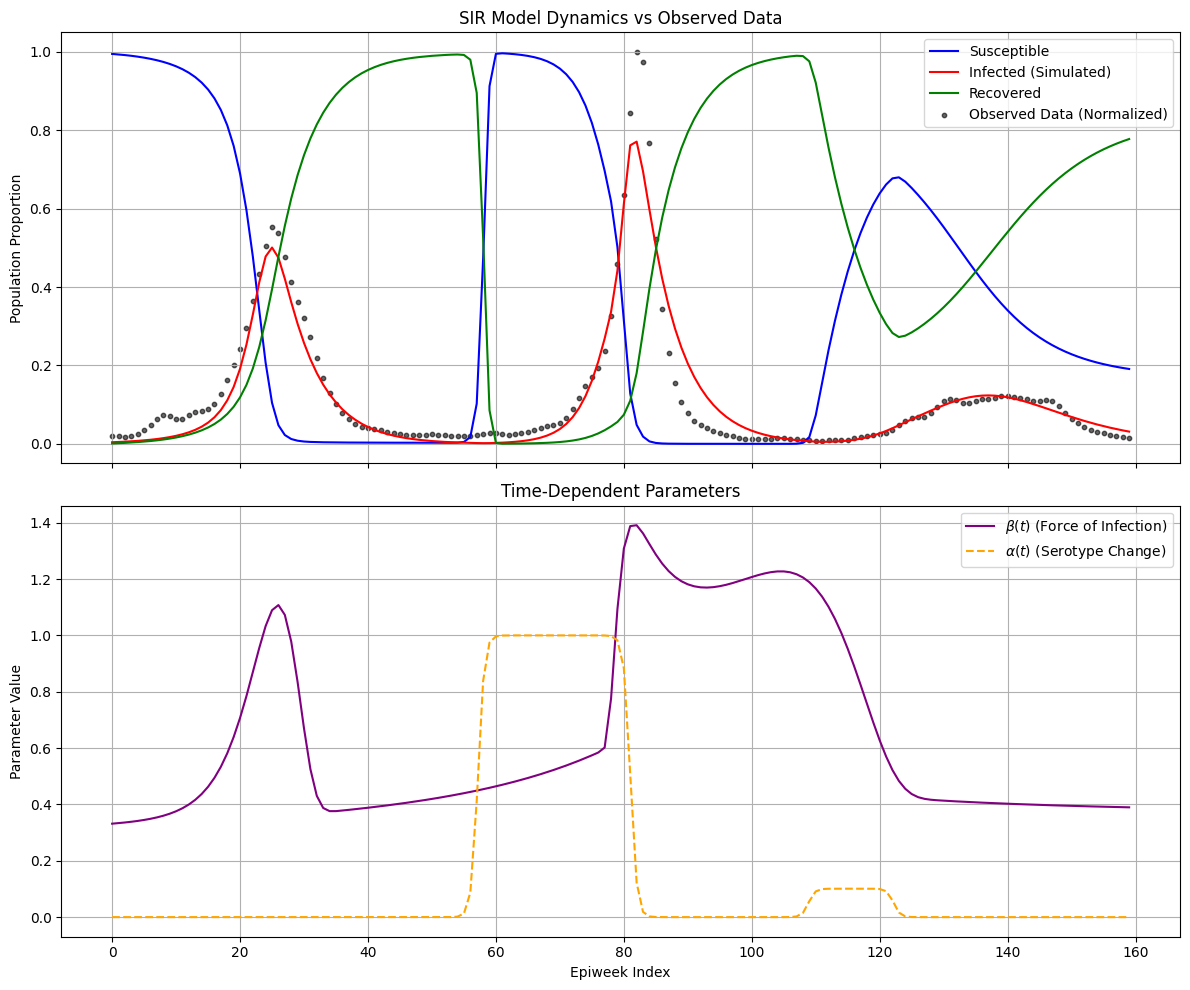

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Unpack parameters again to be sure
(beta_0_opt, A1_opt, t01_opt, sigma1_opt, sk1_opt,
 A2_opt, t02_opt, sigma2_opt, sk2_opt,
 A3_opt, t03_opt, sigma3_opt, sk3_opt, rho_0_opt,
 rho_opt, T_c_opt, l_opt,
 rho2_opt, T_c2_opt, l2_opt,
 gamma_opt, S0_opt, I0_opt, R0_opt) = optimal_params

t_sim = np.arange(len(data_obs))

beta_values_opt = beta_0_opt + gaussian_beta(t_sim, A1_opt, t01_opt, sigma1_opt, sk1_opt) +\
                   gaussian_beta(t_sim, A2_opt, t02_opt, sigma2_opt, sk2_opt) +\
                   gaussian_beta(t_sim, A3_opt, t03_opt, sigma3_opt, sk3_opt)

alpha_values_opt = rho_0_opt + alpha(t_sim, rho_opt, T_c_opt, l_opt) + alpha(t_sim, rho2_opt, T_c2_opt, l2_opt)

# Normalize initial conditions
total_initial_opt = S0_opt + I0_opt + R0_opt
S0_opt /= total_initial_opt
I0_opt /= total_initial_opt
R0_opt /= total_initial_opt

S_sim_opt, I_sim_opt, R_sim_opt = sir_model_simulator(t_sim, beta_values_opt, alpha_values_opt, gamma_opt, S0_opt, I0_opt, R0_opt)

# 4. Create Figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# 5. First subplot: SIR Dynamics
ax1.plot(t_sim, S_sim_opt, label='Susceptible', color='blue')
ax1.plot(t_sim, I_sim_opt, label='Infected (Simulated)', color='red')
ax1.plot(t_sim, R_sim_opt, label='Recovered', color='green')
ax1.scatter(t_sim, data_obs, label='Observed Data (Normalized)', color='black', s=10, alpha=0.6)
ax1.set_ylabel('Population Proportion')
ax1.set_title('SIR Model Dynamics vs Observed Data')
ax1.legend()
ax1.grid(True)

# 6. Second subplot: Parameters Beta and Alpha
ax2.plot(t_sim, beta_values_opt, label=r'$\beta(t)$ (Force of Infection)', color='purple')
ax2.plot(t_sim, alpha_values_opt, label=r'$\alpha(t)$ (Serotype Change)', color='orange', linestyle='--')
ax2.set_xlabel('Epiweek Index')
ax2.set_ylabel('Parameter Value')
ax2.set_title('Time-Dependent Parameters')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

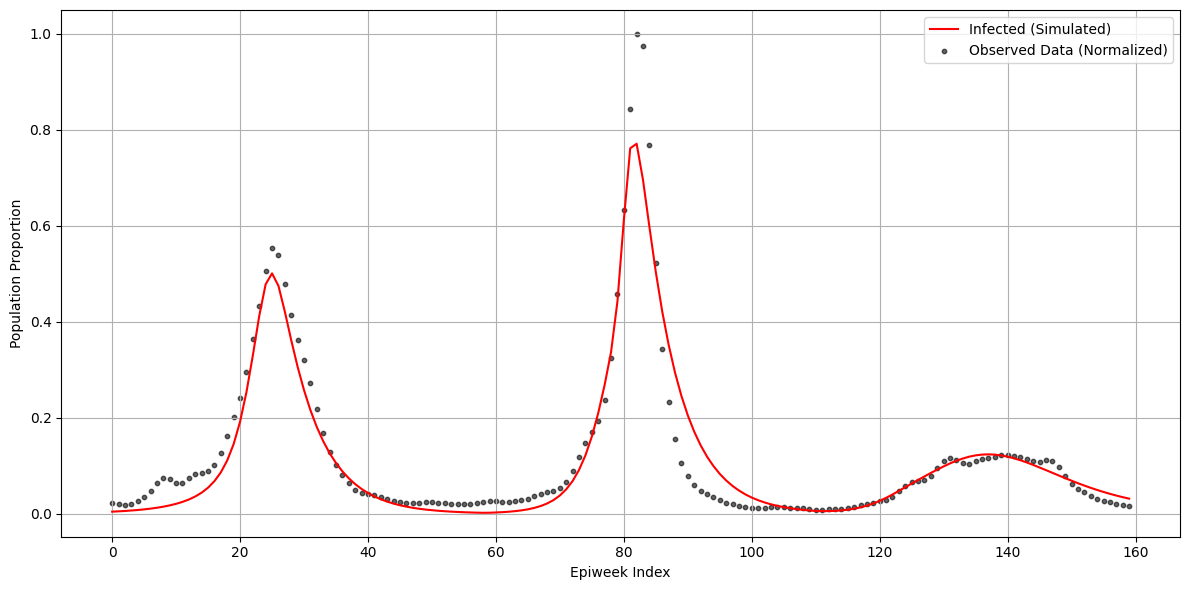

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# --- Eixo principal: S, I, R e dados observados ---
# ax1.plot(t_sim, S_sim_opt, label='Susceptible', color='blue')
ax1.plot(t_sim, I_sim_opt, label='Infected (Simulated)', color='red')
# ax1.plot(t_sim, R_sim_opt, label='Recovered', color='green')
ax1.scatter(t_sim, data_obs, label='Observed Data (Normalized)', color='black', s=10, alpha=0.6)

ax1.set_xlabel('Epiweek Index')
ax1.set_ylabel('Population Proportion')
# ax1.set_title('SIR Dynamics + Time-Dependent Parameters in a Single Figure')
ax1.grid(True)

# --- Segundo eixo: parâmetros β e α ---
# ax2 = ax1.twinx()
# ax2.plot(t_sim, beta_values_opt, label=r'$\beta(t)$', color='purple')
# ax2.plot(t_sim, alpha_values_opt, label=r'$\alpha(t)$', color='orange', linestyle='--')
# ax2.set_ylabel('Parameter Value')

# --- Legendas combinadas ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
# lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1, labels_1, loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import r2_score

# Calculate R-squared
R2 = r2_score(data_obs, I_sim_opt)

print(f"R-squared (R2) of the model: {R2:.4f}")

R-squared (R2) of the model: 0.9269


In [ ]:
optimal_params

array([ 2.49939730e-01,  7.49871267e-01,  2.58493187e+01,  3.80378347e+00,
       -1.72501924e-01,  7.49967831e-01,  8.12913236e+01,  3.55432862e+00,
        4.99805726e-01,  7.49690877e-01,  1.06000418e+02,  1.33578696e+01,
       -3.41525878e-01, -1.59318525e-89,  9.99944908e-01,  6.90954080e+01,
        2.38371448e+01,  1.00920074e-01,  1.15525770e+02,  1.33015303e+01,
        1.65688931e-01,  9.99441642e-01,  4.11589995e-03,  1.00558452e-03])

In [ ]:
param_names = [
    "beta_0", "A1", "t01", "sigma1", "sk1",
    "A2", "t02", "sigma2", "sk2",
    "A3", "t03", "sigma3", "sk3",
    "rho_0", "rho1", "T_c1", "l1",
    "rho2", "T_c2", "l2",
    "gamma", "S0", "I0", "R0"
]

# Ensure optimal_params has the same length as param_names
if len(optimal_params) == len(param_names):
    params_df = pd.DataFrame({
        'Parameter': param_names,
        'Value': optimal_params
    })
    print(params_df)
else:
    print(f"Warning: Mismatch between number of parameters ({len(optimal_params)}) and parameter names ({len(param_names)}).")
    print("Optimized parameters:", optimal_params)


   Parameter         Value
0     beta_0  2.499397e-01
1         A1  7.498713e-01
2        t01  2.584932e+01
3     sigma1  3.803783e+00
4        sk1 -1.725019e-01
5         A2  7.499678e-01
6        t02  8.129132e+01
7     sigma2  3.554329e+00
8        sk2  4.998057e-01
9         A3  7.496909e-01
10       t03  1.060004e+02
11    sigma3  1.335787e+01
12       sk3 -3.415259e-01
13     rho_0 -1.593185e-89
14      rho1  9.999449e-01
15      T_c1  6.909541e+01
16        l1  2.383714e+01
17      rho2  1.009201e-01
18      T_c2  1.155258e+02
19        l2  1.330153e+01
20     gamma  1.656889e-01
21        S0  9.994416e-01
22        I0  4.115900e-03
23        R0  1.005585e-03
